In [1]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import keras

from collections import Counter
from imblearn.over_sampling import SMOTE 

from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,precision_score,f1_score,recall_score
from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras.applications import DenseNet121

import matplotlib.pyplot as plt

import pickle
import joblib
from joblib import dump, load

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import column_or_1d

class MyLabelEncoder(LabelEncoder):

    def fit(self, y):
        y = column_or_1d(y, warn=True)
        self.classes_ = pd.Series(y).unique()
        return self

In [3]:
le = MyLabelEncoder()
le.fit(["No DR", "Mild", "Moderate", "Severe","Proliferative DR"])
dump(le, 'Project Assets/label_encoder.joblib') 

['Project Assets/label_encoder.joblib']

In [4]:
le.transform(["No DR", "Mild", "Moderate", "Severe","Proliferative DR"])

array([0, 1, 2, 3, 4])

In [5]:
data_path="train_images/"
file = "train.csv"
image_size = 150

In [6]:
data = pd.read_csv(file)

In [7]:
#data = data.replace({0:"No DR", 1:"Mild", 2:"Moderate", 3:"Severe",4:"Proliferative DR"})

In [8]:
data = data.replace({0:"No DR", 1:"Mild DR", 2:"Mild DR", 3:"Clear DR",4:"Clear DR"})

In [9]:
output_nodes = len(set(list(data['diagnosis'])))

In [10]:
file_names=list(data['id_code'])

In [11]:
labels=data['diagnosis'].values.ravel()

In [12]:
def image_processing(data_path,file_names,img_size):
    dataset_tumor = []
    for file_name in file_names:
        file=cv2.imread(data_path+file_name+'.png', cv2.IMREAD_COLOR) 
        file_resize=cv2.resize(file,(img_size,img_size))/255.
        dataset_tumor.append(file_resize)
    tumor_data = np.array(dataset_tumor)
    tumor_data = tumor_data.reshape(-1,img_size,img_size,3)
    return tumor_data

In [13]:
#x = image_processing(data_path,file_names,image_size)
#np.save('Project Assets/x_image_data', x)

In [14]:
x = np.load('Project Assets/x_image_data.npy')

In [15]:
x_train_val,x_test,y_train_val,y_test = train_test_split(x,labels,test_size=0.2)

In [16]:
ohe = OneHotEncoder(handle_unknown = "ignore", sparse=False)
ohe = ohe.fit(labels.reshape(-1,1))
y_train_val = ohe.transform(np.array(y_train_val).reshape(-1,1))
y_test = ohe.transform(np.array(y_test).reshape(-1,1))
dump(ohe, 'Project Assets/ohe_encoder.joblib') 

['Project Assets/ohe_encoder.joblib']

In [17]:
densenet = DenseNet121(
    weights='Project Assets/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(image_size,image_size,3)
)

In [18]:
def build_densenet():
    model = Sequential()
    model.add(densenet)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    
    model.add(Dense(units=128, activation='relu'))
    model.add(BatchNormalization())
    #model.add(Dropout(0.5))
    
    model.add(Dense(output_nodes, activation='softmax'))
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0001),
        metrics=['acc']
    )
    
    return model

In [19]:
model = build_densenet()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 3)                 3

In [20]:
def train_densenet(x_train_val, y_train_val):

    ohe = joblib.load('Project Assets/ohe_encoder.joblib')

    kf = KFold(n_splits=3,shuffle=True)
    k_number = 0
    
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_f1score = []
    
    
    print("DenseNet training with 3-Fold Cross Validation.")
    for train_index, test_index in kf.split(x_train_val):
        x_train, x_val = x_train_val[train_index], x_train_val[test_index]
        y_train, y_val = y_train_val[train_index], y_train_val[test_index]
        
        model = build_densenet()
        
        history1 = model.fit(x_train,y_train,epochs=15, validation_split = 0.2)
        
        acc_history = history1.history['acc']
        val_acc_history = history1.history['val_acc']
        loss_history = history1.history['loss']
        val_loss_history = history1.history['val_loss']
        
        plt.plot(history1.history['acc'])
        plt.plot(history1.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(history1.history['loss'])
        plt.plot(history1.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        

        print("The highest validation acc is {}".format(np.max(val_acc_history)))
        
        result=model.predict(x_val)
        result_class = tf.one_hot(np.argmax(result, axis=1), depth = output_nodes)
        
        result_class = ohe.inverse_transform(result_class)
        y_val_class = ohe.inverse_transform(y_val)

        val_accuracy.append(accuracy_score(result_class, y_val_class))
        val_precision.append(precision_score(result_class, y_val_class,average='macro'))
        val_f1score.append(f1_score(result_class, y_val_class,average='macro'))
        val_recall.append(recall_score(result_class, y_val_class,average='macro'))

        average_val_accuracy=sum(val_accuracy)/len(val_accuracy)
        average_val_precision=sum(val_precision)/len(val_precision)
        average_val_recall=sum(val_recall)/len(val_recall)
        average_val_f1score=sum(val_f1score)/len(val_f1score)
        
        print("DenseNet 3-Fold CV:")
        print("Average Acc: %.4f" %(average_val_accuracy))
        print("Average Precision: %.4f" %(average_val_precision))
        print("Average recall: %.4f" %(average_val_recall))
        print("Average F1 Score: %.4f \n" %(average_val_f1score))
        
    model.save('Project Assets/DenseNet_Model')

DenseNet training with 3-Fold Cross Validation.
Epoch 1/15
49/49 [==============================] - 31s 334ms/step - loss: 0.6276 - acc: 0.7463 - val_loss: 0.5384 - val_acc: 0.7877
Epoch 2/15
49/49 [==============================] - 9s 192ms/step - loss: 0.2389 - acc: 0.9142 - val_loss: 0.4667 - val_acc: 0.8286
Epoch 3/15
49/49 [==============================] - 9s 190ms/step - loss: 0.1275 - acc: 0.9635 - val_loss: 0.4818 - val_acc: 0.8389
Epoch 4/15
49/49 [==============================] - 9s 192ms/step - loss: 0.0704 - acc: 0.9853 - val_loss: 0.4632 - val_acc: 0.8389
Epoch 5/15
49/49 [==============================] - 9s 191ms/step - loss: 0.0594 - acc: 0.9898 - val_loss: 0.4284 - val_acc: 0.8645
Epoch 6/15
49/49 [==============================] - 9s 191ms/step - loss: 0.0559 - acc: 0.9853 - val_loss: 0.4789 - val_acc: 0.8465
Epoch 7/15
49/49 [==============================] - 9s 192ms/step - loss: 0.0490 - acc: 0.9891 - val_loss: 0.4733 - val_acc: 0.8491
Epoch 8/15
49/49 [=========

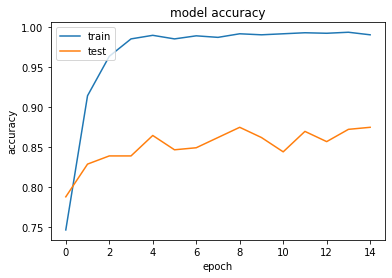

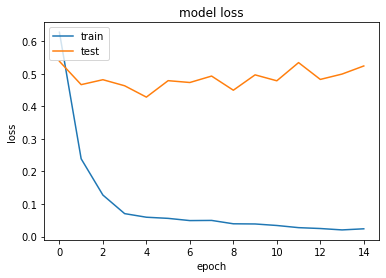

The highest validation acc is 0.8746802806854248
DenseNet 3-Fold CV:
Average Acc: 0.8424
Average Precision: 0.7360
Average recall: 0.7749
Average F1 Score: 0.7459 

Epoch 1/15
49/49 [==============================] - 21s 270ms/step - loss: 0.4753 - acc: 0.8035 - val_loss: 0.6856 - val_acc: 0.6701
Epoch 2/15
49/49 [==============================] - 9s 189ms/step - loss: 0.1687 - acc: 0.9430 - val_loss: 0.5534 - val_acc: 0.7673
Epoch 3/15
49/49 [==============================] - 9s 189ms/step - loss: 0.0905 - acc: 0.9706 - val_loss: 0.4365 - val_acc: 0.8312
Epoch 4/15
49/49 [==============================] - 9s 189ms/step - loss: 0.0644 - acc: 0.9885 - val_loss: 0.4529 - val_acc: 0.8824
Epoch 5/15
49/49 [==============================] - 10s 204ms/step - loss: 0.0489 - acc: 0.9898 - val_loss: 0.4238 - val_acc: 0.8721
Epoch 6/15
49/49 [==============================] - 9s 190ms/step - loss: 0.0295 - acc: 0.9930 - val_loss: 0.4759 - val_acc: 0.8747
Epoch 7/15
49/49 [=======================

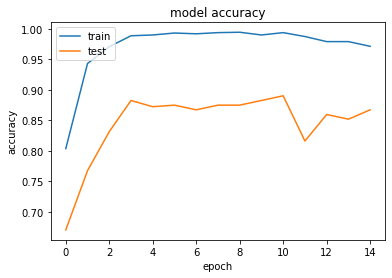

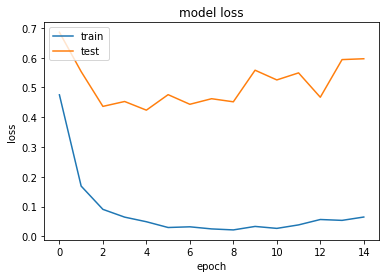

The highest validation acc is 0.8900255560874939
DenseNet 3-Fold CV:
Average Acc: 0.8551
Average Precision: 0.7555
Average recall: 0.8158
Average F1 Score: 0.7710 

Epoch 1/15
49/49 [==============================] - 19s 227ms/step - loss: 0.3992 - acc: 0.8476 - val_loss: 0.4303 - val_acc: 0.8440
Epoch 2/15
49/49 [==============================] - 9s 192ms/step - loss: 0.0988 - acc: 0.9712 - val_loss: 0.3655 - val_acc: 0.8721
Epoch 3/15
49/49 [==============================] - 9s 192ms/step - loss: 0.0490 - acc: 0.9904 - val_loss: 0.4090 - val_acc: 0.8670
Epoch 4/15
49/49 [==============================] - 9s 194ms/step - loss: 0.0451 - acc: 0.9891 - val_loss: 0.4122 - val_acc: 0.8824
Epoch 5/15
49/49 [==============================] - 9s 192ms/step - loss: 0.0385 - acc: 0.9904 - val_loss: 0.4170 - val_acc: 0.8849
Epoch 6/15
49/49 [==============================] - 10s 201ms/step - loss: 0.0515 - acc: 0.9866 - val_loss: 0.4703 - val_acc: 0.8721
Epoch 7/15
49/49 [=======================

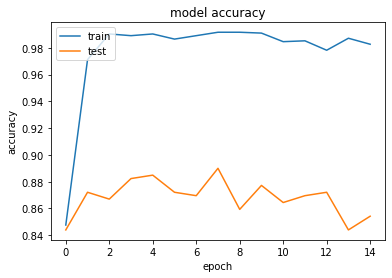

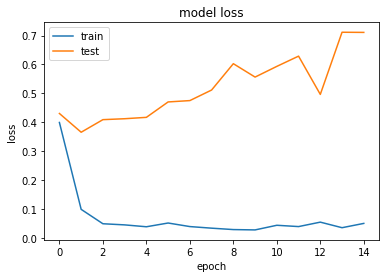

The highest validation acc is 0.8900255560874939
DenseNet 3-Fold CV:
Average Acc: 0.8699
Average Precision: 0.7944
Average recall: 0.8240
Average F1 Score: 0.7977 

INFO:tensorflow:Assets written to: Project Assets/DenseNet_Model\assets


In [21]:
train_densenet(x_train_val, y_train_val)

Accuracy for test data: 0.8376534788540245


<Figure size 504x504 with 0 Axes>

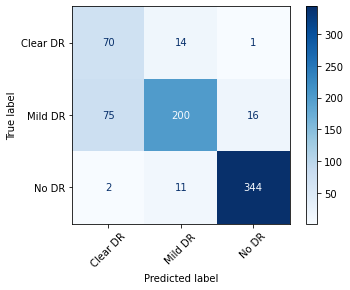

              precision    recall  f1-score   support

    Clear DR       0.48      0.82      0.60        85
     Mild DR       0.89      0.69      0.78       291
       No DR       0.95      0.96      0.96       357

    accuracy                           0.84       733
   macro avg       0.77      0.82      0.78       733
weighted avg       0.87      0.84      0.84       733



In [22]:
model = keras.models.load_model('Project Assets/DenseNet_Model')
ohe = joblib.load('Project Assets/ohe_encoder.joblib')

result=model.predict(x_test)
result_class = tf.one_hot(np.argmax(result, axis=1), depth = output_nodes)

result_class = ohe.inverse_transform(result_class)
y_test_class = ohe.inverse_transform(y_test)

acc = accuracy_score(result_class, y_test_class)
print("Accuracy for test data:", acc)

plt.figure(figsize = (7,7))
ConfusionMatrixDisplay.from_predictions(y_test_class, result_class, cmap = 'Blues')
plt.xticks(rotation=45)
plt.show()
print(classification_report(y_test_class, result_class))